## Find Faces, Crop, Filter, Show

In [38]:
import os
from os.path import exists

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
import time

from mtcnn import MTCNN

import cv2

from csv import writer

from PIL import Image

import ast # str to python expression (e.g. dict)

from datetime import datetime

import pickle

# MTCNN (Multi-Task CNN)
Multi Task CNN performs several tasks simultaneously face detection and face allignment (landmarks).
Original paper: https://arxiv.org/abs/1604.02878  
Github repo: https://github.com/ipazc/mtcnn by https://www.linkedin.com/in/ivandepazcenteno/:   
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

## Scan Photo folder and perfrom MTCNN, save results to a csv file

In [2]:
def get_jpg_filenames(directory):
    list_of_jpg = []
    for (dirpath, dirnames, filenames) in os.walk(directory):
        list_of_jpg   += [os.path.join(dirpath, file) for file in filenames if (file[-3:] == 'jpg') or (file[-3:] == 'JPG')]
    return list_of_jpg

def get_creation_time(file_path):
    image = Image.open(file_path)
    exif = image.getexif()
    creation_date = exif.get(36867)
    return creation_date

def read_image(file_path):
    imageBGR = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) # Use to open unicode folders/files. https://stackoverflow.com/questions/43185605/how-do-i-read-an-image-from-a-path-with-unicode-characters
    image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB) # cv2 uses BGR color ordering, so need to change order for RGB. https://stackoverflow.com/questions/52494592/wrong-colours-with-cv2-imdecode-python-opencv
    return image 

def try_create_csv_file(MTCNN_results_file):
    # Create CSV file for MTCNN results
    if exists(MTCNN_results_file):
        pass
    else:
        row = 'jpg_filename,creation_time,MTCNN_result\n'
        with open(MTCNN_results_file,'a') as file:
            file.write(row)
        
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='', encoding="utf-8") as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)              

        
def get_mtcnn_results(directory, MTCNN_results_file, min_face_size = 200):
    
    detector = MTCNN(min_face_size = min_face_size) # heavy operation, performs every time when called, don't put it in the for loop
    def get_MTCNN_result(file_path):
        image = read_image(file_path)
        return detector.detect_faces(image)     

    try_create_csv_file(MTCNN_results_file)

    df = pd.read_csv(MTCNN_results_file)

    jpg_filenames_list = get_jpg_filenames(directory)
    print(len(jpg_filenames_list), 'jpg files in directory')
    scanned_jpg_list = df['jpg_filename'].tolist()
    print(len(scanned_jpg_list), 'jpg files already scanned before')    

    time.sleep(0.2)
    for filename in tqdm(jpg_filenames_list):
        if filename not in scanned_jpg_list:
            try:
                MTCNN_result = get_MTCNN_result(filename)
                if MTCNN_result != []:
                    creation_time = get_creation_time(filename)
                else:
                    creation_time = None
            except:
                creation_time = None
                MTCNN_result = None
            append_list_as_row(MTCNN_results_file, [filename, creation_time, MTCNN_result])
    time.sleep(0.2)

In [3]:
#%%time
#get_mtcnn_results(r'D:\Photo', r'output\MTCNN_min_face_200.csv', min_face_size = 200)

## Load the results dataframe

In [4]:
df = pd.read_csv(r'output\MTCNN_min_face_200.csv')
print(len(df), 'jpg files scanned')
df.dropna(inplace=True)
print(len(df), 'jpg files with faces detected')
df.tail()

137926 jpg files scanned
58255 jpg files with faces detected


,jpg_filename,creation_time,MTCNN_result
137904,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучш...,2020:03:10 19:43:50,"[{'box': [4241, 1609, 264, 316], 'confidence':..."
137910,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучш...,2020:03:10 20:01:55,"[{'box': [2555, 2789, 405, 444], 'confidence':..."
137912,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучш...,2020:03:10 20:03:51,"[{'box': [1564, 2324, 852, 784], 'confidence':..."
137920,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучш...,2020:03:10 20:03:25,"[{'box': [2805, 1136, 823, 957], 'confidence':..."
137921,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучш...,2020:03:10 20:02:49,"[{'box': [1339, 1015, 496, 652], 'confidence':..."


## Reformat the dataframe

In [5]:
# Format the dataframe

vals = [[]]
for _, row in df.iterrows():    
    file_path = row['jpg_filename']
    creation_date_str = row['creation_time'][0:10]
    creation_date = datetime.strptime(creation_date_str, '%Y:%m:%d')
    result = ast.literal_eval(row['MTCNN_result']) # string to python data format
    face_num=1
    for res in result:
        vals.append([file_path, creation_date, res, face_num])
        columns=['file_path','creation_date', 'MTCNN_result', 'face_num']
        face_num+=1
df_res=pd.DataFrame(vals, columns = columns)
df_res.drop(df_res.index[0], inplace=True)
df_res['face_num']=df_res['face_num'].astype('int8')
df = df_res
df.reset_index(drop=True, inplace=True)


pd.set_option("display.max_colwidth", 200) 
print(len(df))
df.tail()

103401


,file_path,creation_date,MTCNN_result,face_num
103396,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучших домах Лондона\IMG_2716.JPG,2020-03-10,"{'box': [1564, 2324, 852, 784], 'confidence': 0.8960258364677429, 'keypoints': {'left_eye': (1905, 2740), 'right_eye': (2026, 2579), 'nose': (2028, 2791), 'mouth_left': (2078, 2888), 'mouth_right'...",1
103397,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучших домах Лондона\IMG_2716.JPG,2020-03-10,"{'box': [2027, 1126, 509, 545], 'confidence': 0.7314672470092773, 'keypoints': {'left_eye': (2148, 1392), 'right_eye': (2239, 1277), 'nose': (2189, 1360), 'mouth_left': (2245, 1490), 'mouth_right'...",2
103398,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучших домах Лондона\IMG_2712.JPG,2020-03-10,"{'box': [2805, 1136, 823, 957], 'confidence': 0.8441000580787659, 'keypoints': {'left_eye': (3025, 1458), 'right_eye': (3300, 1412), 'nose': (3129, 1567), 'mouth_left': (3040, 1779), 'mouth_right'...",1
103399,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучших домах Лондона\IMG_2699.JPG,2020-03-10,"{'box': [1339, 1015, 496, 652], 'confidence': 0.9996466636657715, 'keypoints': {'left_eye': (1506, 1241), 'right_eye': (1741, 1220), 'nose': (1660, 1340), 'mouth_left': (1547, 1490), 'mouth_right'...",1
103400,D:\Photo\2020.03 Фотосессия Даня и Лиза в лучших домах Лондона\IMG_2699.JPG,2020-03-10,"{'box': [3060, 1018, 480, 781], 'confidence': 0.998498797416687, 'keypoints': {'left_eye': (3143, 1282), 'right_eye': (3330, 1308), 'nose': (3112, 1386), 'mouth_left': (3112, 1604), 'mouth_right':...",2


## Filter photos

In [6]:
def variance_of_laplacian(image): #https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    conv2d = cv2.Laplacian(gray_image, cv2.CV_64F)    
    return int((conv2d.max() - conv2d.min())**2/(2*conv2d.var())) # int((conv2d.max() - conv2d.min())**2/2), int(conv2d.var()), 

def mark_landmarks(image, keypoints, landmark_color = (0,255,0)):
    #cv2.rectangle(image,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),landmark_color,1)
    cv2.circle(image,(keypoints['left_eye']), 1, landmark_color, 2) # circle diameter, landmark_color, line thickness
    cv2.circle(image,(keypoints['right_eye']), 1, landmark_color, 2)
    cv2.circle(image,(keypoints['nose']), 1, landmark_color, 2)
    cv2.circle(image,(keypoints['mouth_left']), 1, landmark_color, 2)
    cv2.circle(image,(keypoints['mouth_right']), 1, landmark_color, 2)
    return image


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated_image

def get_rotated_keypoints(keypoints, rot_mat):
    
    def get_rotated_coordinate(rot_mat, old_coord): #https://cristianpb.github.io/blog/image-rotation-opencv
        expanded_coord = old_coord + (1,) 
        product = np.dot(rot_mat,expanded_coord)
        new_coord = int(product[0]), int(product[1])               
        return new_coord
    
    keypoints_rotated = keypoints.copy()
    for key, value in keypoints_rotated.items():
        keypoints_rotated[key] = get_rotated_coordinate(rot_mat, value)
    return keypoints_rotated

def is_not_grayscale(image):    
    return image[:, :, 0].sum() != image[:, :, 1].sum()

def resize_image(image, new_size):
    # new_size is tuple: e.g. (224, 224)
    #height, width, channels = image.shape
    #print(height, width, channels)
    image_resized = cv2.resize(image, new_size)
    #height, width, channels = image_resized.shape
    #print(height, width, channels)
    return image_resized
#image = read_image(r"D:\Photo\2020.06.13-14 Cotswlds, Oxford, Cambridge/Img_3820.jpg")
#resized_image = resize_image(image, new_size=(224, 224))
#plt.imshow(resized_image)

In [7]:
#df1=df.copy()

In [8]:
#df = df1[40000:41000]

In [9]:
%%time

confidence_filter = 0.99
face_height_filter = 160
nose_shift_filter = 5
eye_line_angle_filter = 20
sharpness_filter = 200
show_landmarks = False
save_image = True
preview = False


img_cnt = 0
good_img_cnt = 0
df['face_file_path'] = np.NaN

# iterate over photos
for index, row in tqdm(df.iterrows()):
    try:
        img_cnt += 1
        creation_date = row['creation_date']    
        res = row['MTCNN_result']
        confidence = res['confidence']
        bounding_box = res['box']
        keypoints = res['keypoints']
        upper_left_x, upper_left_y, width, height  = bounding_box

        # change box to square
        side = max(height, width)
        upper_left_x = int(upper_left_x + width/2 - side/2)
        width=height=side

        if (confidence >= confidence_filter) and (height >= face_height_filter):

            # find an angle of line of eyes.
            dY = keypoints['right_eye'][1] - keypoints['left_eye'][1]
            dX = keypoints['right_eye'][0] - keypoints['left_eye'][0]
            angle = np.degrees(np.arctan2(dY,dX))

            # calculate rotation matrix for this anlge around nose as a central point 
            rot_mat = cv2.getRotationMatrix2D(keypoints['nose'], angle, 1.0)

            # calculate new coordinates of keypoints
            keypoints_rotated = get_rotated_keypoints(keypoints, rot_mat)

            # calculate nose shift
            nose_shift = 100*abs((keypoints_rotated['nose'][0] - keypoints_rotated['left_eye'][0] - dX/2)/dX)

            if (nose_shift <= nose_shift_filter) and (abs(angle) <= eye_line_angle_filter):
                image = read_image(row.file_path)

                if is_not_grayscale(image):

                    image_rotated = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

                    #nose_x = keypoints['nose'][0]
                    #nose_y = keypoints['nose'][1]
                    #image_cropped_central_part = image_rotated[int(nose_y-side*1/10):int(nose_y+side*1/12), int(nose_x-side*1/10):int(nose_x+side*1/10)]

                    image_cropped_central_part = image_rotated[int(upper_left_y+height*1/2):int(upper_left_y + height*2/3), int(upper_left_x+width*1/3):int(upper_left_x + width*2/3)]

                    sharpness = variance_of_laplacian(image_cropped_central_part)

                    if sharpness >= sharpness_filter:

                        if show_landmarks == True:

                            image_rotated = mark_landmarks(image_rotated, keypoints_rotated)

                        image_cropped = image_rotated[upper_left_y:upper_left_y + height, upper_left_x:upper_left_x + width]


                        if  preview == True:
                            print(good_img_cnt, 'image from total of', img_cnt, 'scanned images')
                            print(row.file_path)
                            print('angle =',int(angle), '; nose shift =', int(nose_shift), '; sharpness =', int(sharpness))
                            #plt.imshow(image_cropped_central_part)
                            #plt.show()
                            plt.imshow(image_cropped)
                            plt.show()
                        good_img_cnt+=1

                        if save_image == True:
                            imagefile_path = 'output/face_photos/' + str(index) +'.jpg'
                            cv2.imwrite(imagefile_path, cv2.cvtColor(image_cropped, cv2.COLOR_RGB2BGR))
                            df['face_file_path'].iloc[index] = imagefile_path
    except:
        pass

362it [00:09, 33.46it/s]C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
103401it [1:36:43, 17.82it/s]

Wall time: 1h 36min 44s


In [10]:
df.dropna(inplace=True)
print(len(df))
df.to_csv(r'output\MTCNN_min_face_200_filtered.csv')

1753


## Get FaceNet Embeddings

In [43]:
from keras.models import load_model

from keras.preprocessing.image import img_to_array

In [103]:
def standardize_image(image):
    mean, std = image.mean(), image.std()
    return (image - mean) / std

def get_facenet_embedding(image_path, model):
    image = read_image(image_path)
    image = cv2.resize(image, (160,160))
    image=standardize_image(image)
    input_arr = img_to_array(image) # Convert single image to a batch.
    input_arr = np.array([input_arr])
    return model.predict(input_arr)[0,:]    

In [42]:
df = pd.read_csv(r'output\MTCNN_min_face_200_modified.csv')
print(len(df), 'photos')
df.head()

1753 photos


,Unnamed: 0,file_path,creation_date,MTCNN_result,face_num,face_file_path
0,391,D:\Photo\2012.12.26-05 Джермания\I-phone\IMG_0118.JPG,2012-12-26,"{'box': [1555, 1300, 329, 389], 'confidence': 0.9958587288856506, 'keypoints': {'left_eye': (1636, 1459), 'right_eye': (1778, 1409), 'nose': (1739, 1544), 'mouth_left': (1700, 1603), 'mouth_right'...",1,output/face_photos/391.jpg
1,400,D:\Photo\2012.12.26-05 Джермания\I-phone\IMG_0627.JPG,2012-12-26,"{'box': [325, 1268, 442, 647], 'confidence': 0.9950939416885376, 'keypoints': {'left_eye': (437, 1530), 'right_eye': (668, 1536), 'nose': (547, 1691), 'mouth_left': (452, 1767), 'mouth_right': (64...",1,output/face_photos/400.jpg
2,519,D:\Photo\2008.07.20 Приключения итальянцев в России\S7300385.JPG,2008-07-20,"{'box': [1399, 768, 379, 455], 'confidence': 0.999962329864502, 'keypoints': {'left_eye': (1495, 952), 'right_eye': (1664, 915), 'nose': (1592, 1027), 'mouth_left': (1546, 1108), 'mouth_right': (1...",3,output/face_photos/519.jpg
3,639,D:\Photo\2008.10 Осень\S7300402.jpg,2008-10-15,"{'box': [1095, 881, 307, 428], 'confidence': 0.999861478805542, 'keypoints': {'left_eye': (1178, 1058), 'right_eye': (1332, 1046), 'nose': (1267, 1165), 'mouth_left': (1189, 1199), 'mouth_right': ...",1,output/face_photos/639.jpg
4,640,D:\Photo\2008.10 Осень\S7300403.JPG,2008-10-15,"{'box': [1538, 565, 304, 403], 'confidence': 0.9995158910751343, 'keypoints': {'left_eye': (1614, 740), 'right_eye': (1762, 714), 'nose': (1708, 837), 'mouth_left': (1646, 873), 'mouth_right': (17...",1,output/face_photos/640.jpg


In [104]:
# load the pretrained facenet model
model = load_model(r'facenet_keras_pretrained/model/facenet_keras.h5')
#print(model.inputs)
#print(model.outputs)
#model.summary()

In [106]:
%%time
embeddings = []
for file_path in df['face_file_path']:
    emb = get_facenet_embedding(file_path, model)
    embeddings.append(emb)
embeddings = np.array(embeddings)
embeddings.shape

Wall time: 3min 46s


(1753, 128)

In [109]:
np.save('output/embeddings', embeddings)

## t-SNE

In [113]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [143]:
X = np.load('output/embeddings.npy')
X.shape

(1753, 128)

C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


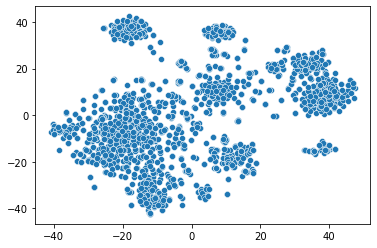

In [163]:
X_embedded = TSNE(perplexity=40, learning_rate = 1000, n_iter=500).fit_transform(X)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1])

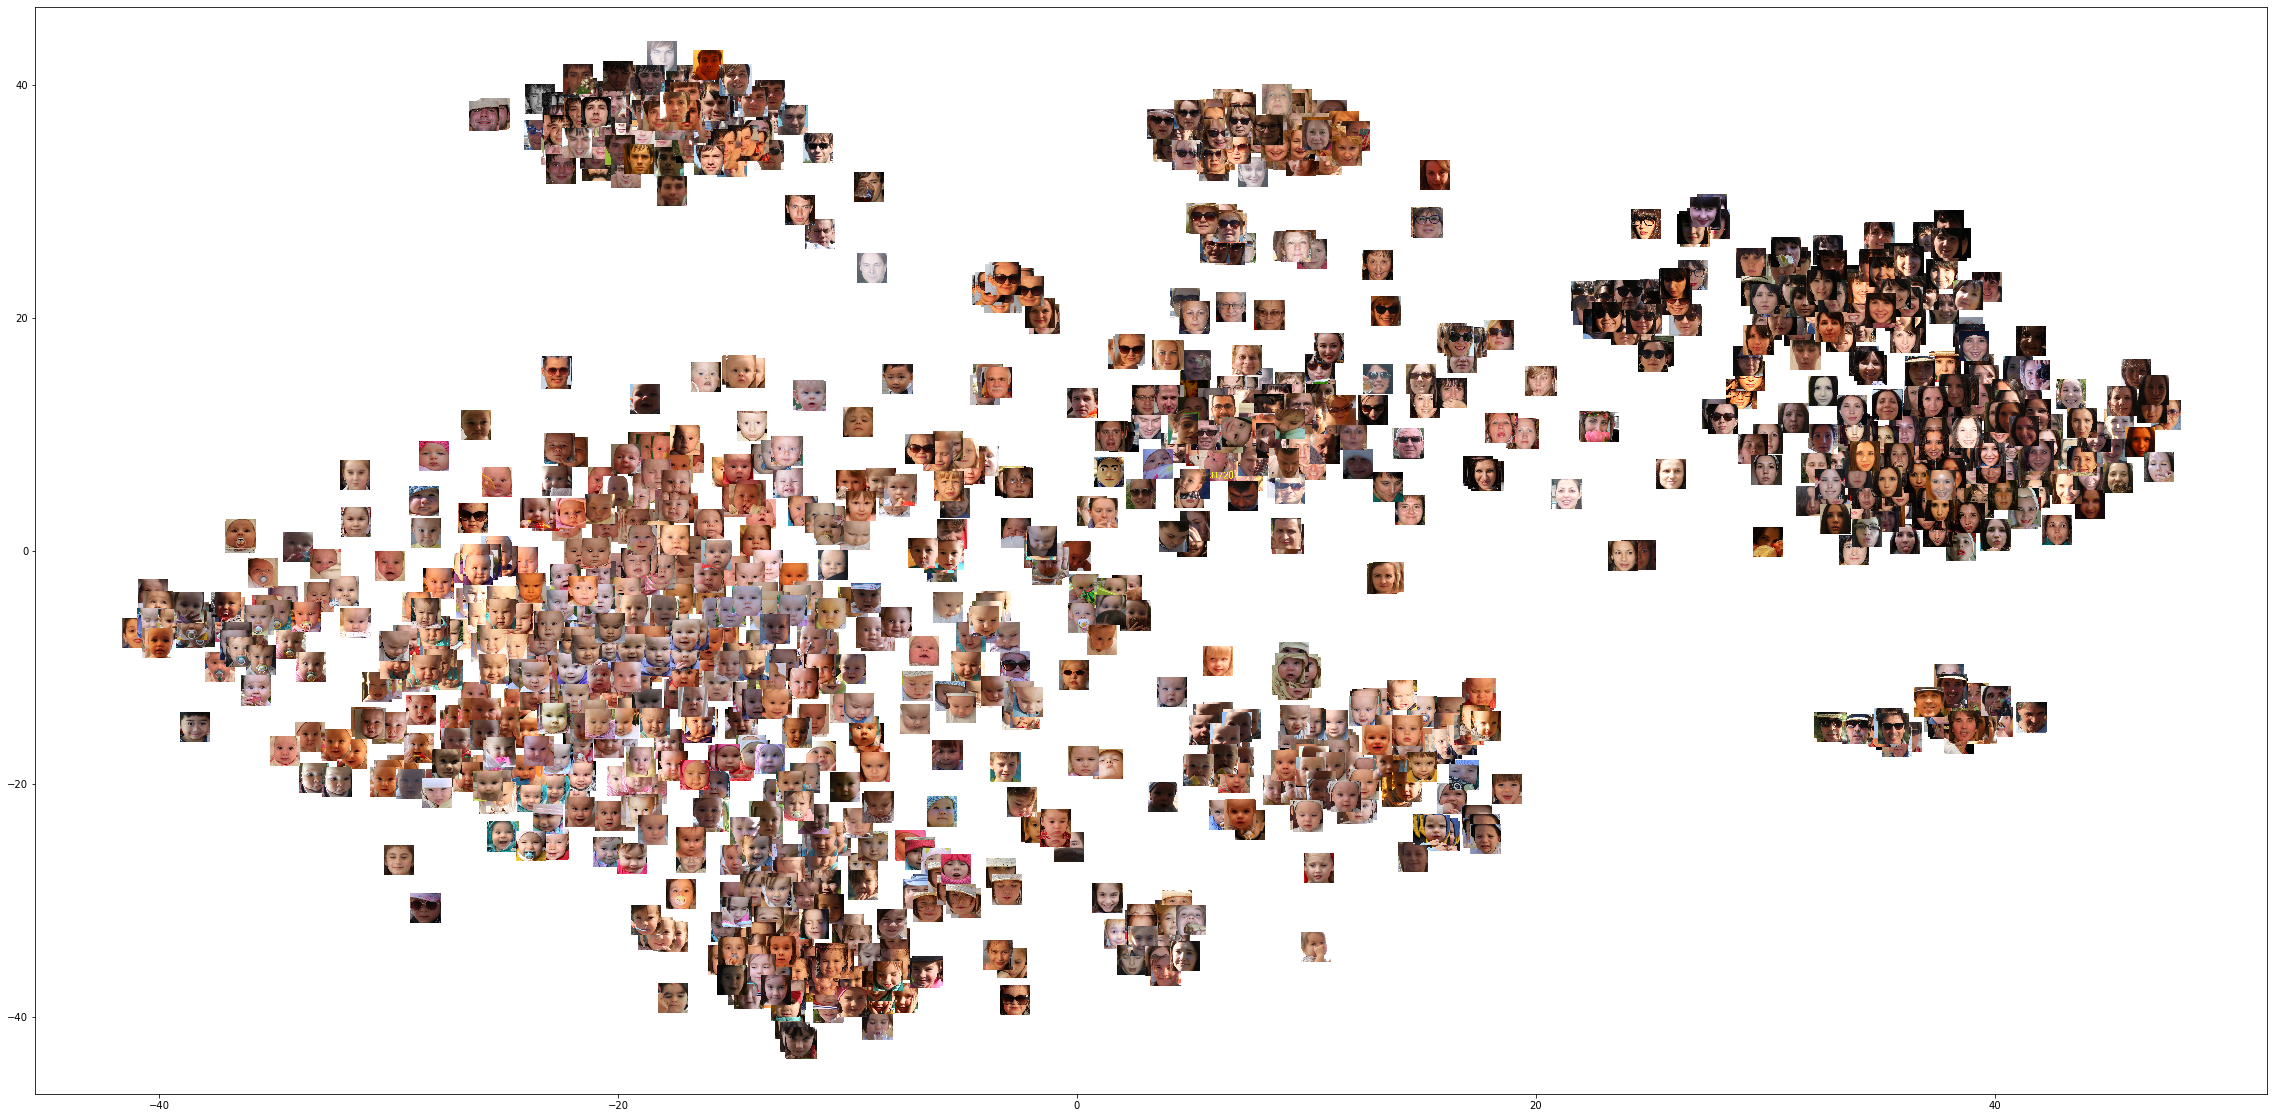

In [164]:
# https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
def getImage(path):
    image = plt.imread(path)
    image = resize_image(image, (30,30))
    return OffsetImage(image)

paths =  df.face_file_path
x = X_embedded[:,0]
y = X_embedded[:,1]

fig, ax = plt.subplots(figsize=(40, 20))
ax.scatter(x, y) 

for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)